<a href="https://colab.research.google.com/github/northpr/tensorflow-resources/blob/main/udemy_tensorflow_course/05_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2022-09-18 11:20:29--  https://raw.githubusercontent.com/northpr/helper_function/master/tensorflow/helper_tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3457 (3.4K) [text/plain]
Saving to: ‘helper_tensorflow.py’

helper_tensorflow.p 100%[===================>]   3.38K  --.-KB/s    in 0s      

2022-09-18 11:20:29 (52.8 MB/s) - ‘helper_tensorflow.py’ saved [3457/3457]

--2022-09-18 11:20:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16854

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
from helper_tensorflow import *

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=(224,224),
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=(224,224),
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent.class_names, train_data_10_percent

(['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'],
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

In [ ]:
test_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Build model 0 with augmentation layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from helper_tensorflow import *

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
input_shape = (224,224,3)

# 1. Create base model with tf.keras.applications
base_model_resnet = tf.keras.applications.ResNet50V2(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model_resnet.trainable = False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# 4. Using ResNet50V2, add this to speed up convergence, remove from EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base_model (note:  using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model_resnet(inputs)
# Check data shape after passing it to base_model:
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[callback_create_tensorboard(dir_name="tensorflow_hub",
                                                               experiment_name="ResNet50V2")])

In [ ]:
for layer_number, layer in enumerate(base_model_resnet.layers):
  print(layer_number, layer.name)

In [ ]:
model_0.summary()

In [ ]:
plot_loss_curves(history_0)

## Model 1

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 5. Pass the inputs to the base model
x = base_model(inputs)

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average__pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[callback_create_tensorboard("tensorflow_hub","EfficientNetV2")])

## Model 2

In [ ]:
# 1. Create base model with tf.keras.applications
base_model_efficient_v2 = tf.keras.applications.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model_efficient_v2.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 5. Pass the inputs to the base model
x = base_model_efficient_v2(inputs)

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_2 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[callback_create_tensorboard("tensorflow_hub","EfficientNetV2_2")])

## Model 3 

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
base_model_3 = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model_3.trainable = False

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. Data data_augmentation
x = data_augmentation(inputs)

# 5. Pass the inputs to the base model
x = base_model_3(x)

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_max_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_3 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[callback_create_tensorboard("tensorflow_hub","EfficientNetV2_3"),
                                   checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/EfficientNetV2_3/20220918-112043
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0293 - accuracy: 0.3360
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 651ms/step - loss: 2.0293 - accuracy: 0.3360 - val_loss: 1.4891 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 523ms/step - loss: 1.3930 - accuracy: 0.6640 - val_loss: 1.0692 - val_accuracy: 0.7418
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0994 - accuracy: 0.7413
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 419ms/step - loss: 1.0994 - accuracy: 0.7413 - val_loss: 0.8558 - val_accuracy: 0.7895
Epoch 4

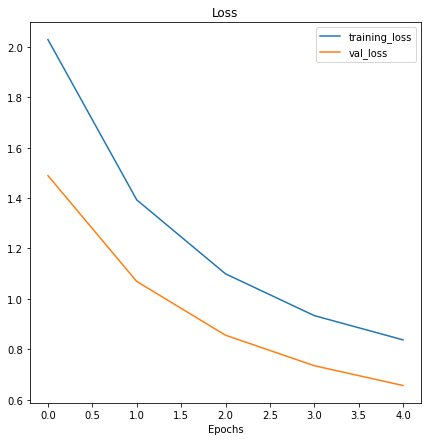

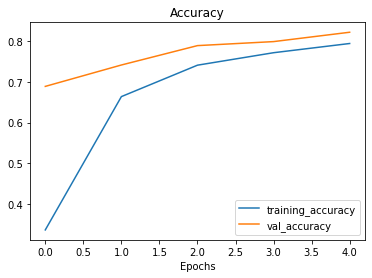

In [ ]:
plot_loss_curves(history_3)

In [ ]:
model_3.load_weights(checkpoint_path)
loaded_weights_model_results = model_3.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.6670 - accuracy: 0.8208


## Model 3_v2 Unfreeze 10 layers

In [ ]:
for layer in base_model_3.layers[-10:]:
  layer.trainable=True

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
for number, layer in enumerate(base_model_3.layers[-30:]):
  print(number, layer.name, layer.trainable)

0 block6g_expand_bn False
1 block6g_expand_activation False
2 block6g_dwconv2 False
3 block6g_bn False
4 block6g_activation False
5 block6g_se_squeeze False
6 block6g_se_reshape False
7 block6g_se_reduce False
8 block6g_se_expand False
9 block6g_se_excite False
10 block6g_project_conv False
11 block6g_project_bn False
12 block6g_add False
13 block6h_expand_conv False
14 block6h_expand_bn False
15 block6h_expand_activation False
16 block6h_dwconv2 False
17 block6h_bn False
18 block6h_activation False
19 block6h_se_squeeze False
20 block6h_se_reshape True
21 block6h_se_reduce True
22 block6h_se_expand True
23 block6h_se_excite True
24 block6h_project_conv True
25 block6h_project_bn True
26 block6h_add True
27 top_conv True
28 top_bn True
29 top_activation True


In [ ]:
history_fine_10_percent = model_3.fit(train_data_10_percent,
                                      epochs=10,
                                      validation_data=test_data_10_percent,
                                      initial_epoch=history_3.epoch[-1],
                                      validation_steps=int(0.25*len(test_data_10_percent)),
                                      callbacks=[callback_create_tensorboard("tensorflow_hub","fine_tuning")])
                                      

Saving TensorBoard log files to: tensorflow_hub/fine_tuning/20220918-112224
Epoch 5/10
24/24 [==============================] - 18s 499ms/step - loss: 0.9823 - accuracy: 0.7560 - val_loss: 0.7720 - val_accuracy: 0.8043
Epoch 6/10
24/24 [==============================] - 9s 354ms/step - loss: 0.9336 - accuracy: 0.7853 - val_loss: 0.7669 - val_accuracy: 0.8059
Epoch 7/10
24/24 [==============================] - 11s 449ms/step - loss: 0.9358 - accuracy: 0.7787 - val_loss: 0.7345 - val_accuracy: 0.8092
Epoch 8/10
24/24 [==============================] - 10s 392ms/step - loss: 0.8943 - accuracy: 0.7707 - val_loss: 0.7430 - val_accuracy: 0.8026
Epoch 9/10
24/24 [==============================] - 9s 346ms/step - loss: 0.8898 - accuracy: 0.7960 - val_loss: 0.7213 - val_accuracy: 0.8076
Epoch 10/10
24/24 [==============================] - 8s 323ms/step - loss: 0.8853 - accuracy: 0.7773 - val_loss: 0.7090 - val_accuracy: 0.8109


## Model_3 v3 Fine tuning all data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2022-09-18 11:23:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  79.6MB/s    in 6.8s    

2022-09-18 11:23:40 (73.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=(224,224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224))

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Load weight
model_3.load_weights(checkpoint_path)
model_3.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.6670 - accuracy: 0.8208


[0.6669556498527527, 0.8208000063896179]

In [ ]:
for layer_number, layer in enumerate(model_3.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_max_pooling_layer True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model_3.layers):
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
block4a_se_reduce False
block4a_se_expand Fal

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics="accuracy")

history_3_10_classes_full = model_3.fit(train_data_10_classes_full,
                                        epochs=10,
                                        initial_epoch=history_3.epoch[-1],
                                        validation_data=test_data,
                                        validation_steps=int(0.25*len(test_data)),
                                        callbacks=[callback_create_tensorboard("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220918-112837
Epoch 5/10
235/235 [==============================] - 66s 256ms/step - loss: 1.0281 - accuracy: 0.7256 - val_loss: 0.6936 - val_accuracy: 0.8240
Epoch 6/10
235/235 [==============================] - 48s 205ms/step - loss: 0.9339 - accuracy: 0.7496 - val_loss: 0.5874 - val_accuracy: 0.8553
Epoch 7/10
235/235 [==============================] - 42s 175ms/step - loss: 0.8707 - accuracy: 0.7628 - val_loss: 0.5503 - val_accuracy: 0.8586
Epoch 8/10
235/235 [==============================] - 38s 160ms/step - loss: 0.8242 - accuracy: 0.7664 - val_loss: 0.5047 - val_accuracy: 0.8684
Epoch 9/10
235/235 [==============================] - 37s 153ms/step - loss: 0.7970 - accuracy: 0.7728 - val_loss: 0.4940 - val_accuracy: 0.8536
Epoch 10/10
235/235 [==============================] - 34s 141ms/step - loss: 0.7628 - accuracy: 0.7869 - val_loss: 0.4591 - val_accuracy: 0.8734


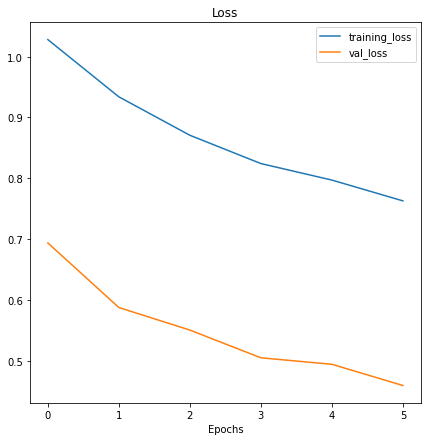

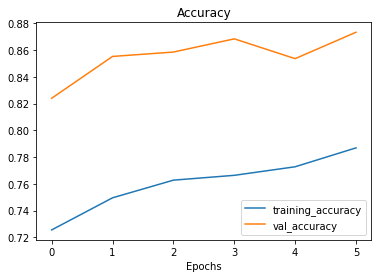

In [ ]:
plot_loss_curves(history_3_10_classes_full)